In [130]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [74]:
# Read crypto_data.csv into Pandas
crypto_df = pd.read_csv('crypto_data.csv')

# Discard all cryptocurrencies that are not being traded
crypto_df = crypto_df.loc[(crypto_df['IsTrading'] == True)]

# drop the IsTrading column from the dataframe
crypto_df = crypto_df.drop(columns="IsTrading")

# Remove all rows that have at least one null value.
crypto_df = crypto_df.dropna()

# Filter for cryptocurrencies that have been mined
crypto_df = crypto_df.loc[(crypto_df['TotalCoinsMined'] > 0)]

# delete the CoinName from the original dataframe
crypto_df = crypto_df.drop(columns='CoinName')
crypto_df = crypto_df.set_index('Unnamed: 0')

crypto_df['TotalCoinSupply'] = crypto_df['TotalCoinSupply'].astype(float)

crypto_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,
42,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
404,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
1337,X13,PoW/PoS,2.927942e+10,3.141593e+11
BTC,SHA-256,PoW,1.792718e+07,2.100000e+07
ETH,Ethash,PoW,1.076842e+08,0.000000e+00


In [112]:
# convert the remaining features with text values, Algorithm and ProofType, into numerical data

crypto_dummies = pd.get_dummies(crypto_df)

# Standardize the dataset so that columns that contain larger values do not unduly influence the outcome
scaler = StandardScaler()
crypto_scaled_data = scaler.fit_transform(crypto_dummies[['TotalCoinsMined', 'TotalCoinSupply']])
crypto_scaled = pd.DataFrame(crypto_scaled_data, columns=crypto_dummies.columns[0:2])

# Replacing columns with scaled columns
crypto_dummies = crypto_dummies.reset_index()
crypto_dummies['TotalCoinsMined'] = crypto_scaled['TotalCoinsMined']
crypto_dummies['TotalCoinSupply'] = crypto_scaled['TotalCoinSupply']
crypto_dummies = crypto_dummies.drop(columns='Unnamed: 0')
crypto_processed = crypto_dummies

In [125]:
# Initialize PCA model
pca = PCA(n_components=0.90)

crypto_pca = pca.fit_transform(crypto_processed)

# 12 principal columns
df_crypto_pca = pd.DataFrame(
    data=crypto_pca,
    columns=["principal component 1", "principal component 2", "principal component 3", "principal component 4", "principal component 5", "principal component 6", "principal component 7", "principal component 8", "principal component 9", "principal component 10", "principal component 11", "principal component 12"]
)

df_crypto_pca.head()


,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12
0,-0.209276,-0.801765,0.172975,-0.672385,-0.028027,-0.027350,0.002161,-0.016859,-0.047423,-0.023043,-0.007850,0.015789
1,-0.187390,-0.804259,0.162555,-0.673029,-0.028782,-0.027213,0.002265,-0.017852,-0.047565,-0.023081,-0.007752,0.015888
2,3.529674,-0.305537,2.915403,0.414815,-0.163323,-0.259278,-0.278472,-0.152434,0.747395,0.360814,-0.233801,-0.070220
3,-0.180157,0.694290,-0.165771,0.239931,-0.278380,-0.614707,0.624124,-0.015063,0.027769,0.009259,-0.026164,-0.026461
4,-0.173289,0.688569,-0.154390,0.131918,-0.212548,-0.104388,-0.242103,0.002800,0.113068,-0.125626,0.058157,-0.129333


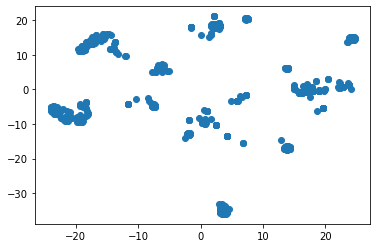

In [129]:
# Initialize t-SNE model
tsne = TSNE(learning_rate=35)

# Reduce dimensions
crypto_tsne = tsne.fit_transform(df_crypto_pca)

df_crypto_tsne = pd.DataFrame(
    data=crypto_tsne,
    columns=["x", "y"]
)

plt.scatter(df_crypto_tsne['x'],df_crypto_tsne['y'])
plt.show()

C:\Users\Chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


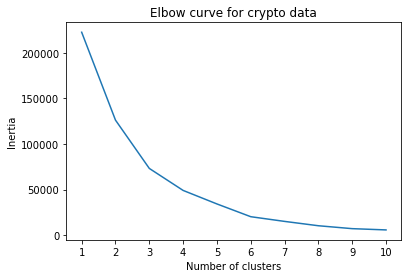

In [135]:
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_tsne)
    inertia.append(km.inertia_)
    
    
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for crypto data')
plt.show()

In [136]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [151]:
clusters = get_clusters(6, df_crypto_tsne)

In [152]:
clusters

,x,y,class
0,-24.049568,-5.118130,5
1,-18.257368,-7.384410,5
2,-5.894737,7.131801,0
3,23.870703,14.830009,1
4,22.903603,0.695087,1
...,...,...,...
527,6.287496,-1.800236,2
528,-21.183969,-9.236859,5
529,13.784469,5.993283,1
530,19.617720,-5.440552,1


In [153]:
def show_clusters(df):
    plt.scatter(df['x'], df['y'], c=df['class'])
    plt.show()

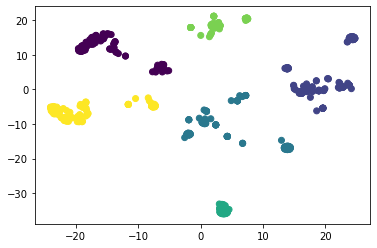

In [154]:
show_clusters(clusters)

## Looking at the scatter plot and elbow curve, I believe the cryptocurrencies can be clustered together in optimally 6 clusters. This is due to the elbow located at k=6 on the elbow curve.